In [1]:
import os
import torch
from copy import deepcopy
import numpy as np
import xarray as xr
import pandas as pd
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from sklearn import preprocessing
import zipfile
import shutil
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
device

'cuda'

In [2]:
def set_seed(seed = 427):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)

In [3]:
class EarthDataSet(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['sst'])

    def __getitem__(self, idx):   
        return (self.data['sst'][idx], self.data['t300'][idx], self.data['ua'][idx], self.data['va'][idx]), self.data['label'][idx]

In [4]:
def scale_data(data_list):
    a,b,c,d = data_list[0].shape
    all_data = []
    for data in data_list:
        new_data = data.reshape(-1)
        all_data.append(new_data)
    all_data = np.stack(all_data,1)
    print(all_data.shape)
    all_data = preprocessing.scale(all_data)
    res_data = []
    for i in range(all_data.shape[1]):
        data = all_data[:,i].reshape(a,b,c,d)
        res_data.append(data)
    return res_data

In [5]:
def load_data():
    # CMIP data    
    train = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_train.nc')
    label = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_label.nc')    
   
    train_sst = train['sst'][:, :12].values  # (4645, 12, 24, 72)
    train_t300 = train['t300'][:, :12].values
    train_ua = train['ua'][:, :12].values
    train_va = train['va'][:, :12].values
    train_label = label['nino'][:, 12:36].values

    train_ua = np.nan_to_num(train_ua) # trans nan to 0
    train_va = np.nan_to_num(train_va)
    train_t300 = np.nan_to_num(train_t300)
    train_sst = np.nan_to_num(train_sst)
    
    data_list = [train_sst,train_t300,train_ua,train_va]
    train_sst,train_t300,train_ua,train_va = scale_data(data_list)

    # SODA data    
    train2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_train.nc')
    label2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_label.nc')
    
    train_sst2 = train2['sst'][:, :12].values  # (100, 12, 24, 72)
    train_t3002 = train2['t300'][:, :12].values
    train_ua2 = train2['ua'][:, :12].values
    train_va2 = train2['va'][:, :12].values
    train_label2 = label2['nino'][:, 12:36].values
    
    train_sst2 = np.nan_to_num(train_sst2) # trans nan to 0
    train_t3002 = np.nan_to_num(train_t3002)
    train_ua2 = np.nan_to_num(train_ua2)
    train_va2 = np.nan_to_num(train_va2)
    
    data_list = [train_sst2,train_t3002,train_ua2,train_va2]
    train_sst2,train_t3002,train_ua2,train_va2 = scale_data(data_list)

    print('Train samples: {}, Valid samples: {}'.format(len(train_label), len(train_label2)))

    dict_train = {
        'sst':train_sst,
        't300':train_t300,
        'ua':train_ua,
        'va': train_va,
        'label': train_label}
    dict_valid = {
        'sst':train_sst2,
        't300':train_t3002,
        'ua':train_ua2,
        'va': train_va2,
        'label': train_label2}
    train_dataset = EarthDataSet(dict_train)
    valid_dataset = EarthDataSet(dict_valid)
    return train_dataset, valid_dataset

In [6]:
set_seed()
train_dataset, valid_dataset = load_data()      
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

(96318720, 4)
(2073600, 4)
Train samples: 4645, Valid samples: 100


In [7]:
def coreff(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    c1 = sum((x - x_mean) * (y - y_mean))
    c2 = sum((x - x_mean)**2) * sum((y - y_mean)**2)
    return c1/np.sqrt(c2)

def rmse(preds, y):
    r = np.sqrt(sum((preds - y)**2) / preds.shape[0])
    return r

def eval_score(preds, label):
    acskill_socre = 0
    rmse_score = 0
    a = [1.5]*4 + [2]*7 + [3]*7 + [4]*6
    for i in range(24):
        r = rmse(preds[:, i], label[:, i], ) # T时刻 (100,)
        cor = coreff(preds[:, i], label[:, i], )
    
        rmse_score += r
        acskill_socre += a[i] * np.log(i+1) * cor
    print("acskill_socre:{}, rmse_score:{}".format(2/3*acskill_socre, rmse_score))
    return 2/3 * acskill_socre - rmse_score

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def train(num_epochs):
    best_score = -99
    loss_epoch = []
    for epoch in range(num_epochs):
        model.train()
        all_loss = []
        for step, ((sst, t300, ua, va), label) in enumerate(train_loader):                
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            optimizer.zero_grad()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)
            loss = loss_fn(preds, label)
            loss.backward()
            optimizer.step()
            all_loss.append(loss.item())
            if step%20 == 0:
                print('Step: {}, Train Loss: {}'.format(step, loss))
        print('Epoch: {}, Train loss: {}'.format(epoch+1, np.mean(all_loss)))
        loss_epoch.append(np.mean(all_loss))

        model.eval()
        y_true, y_pred = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)

            y_pred.append(preds)
            y_true.append(label)

        y_true = torch.cat(y_true, axis=0).cpu().detach().numpy()
        y_pred = torch.cat(y_pred, axis=0).cpu().detach().numpy()
        x_month = np.arange(24)
        score = eval_score(y_true, y_pred)
        print('Epoch: {}, Valid Score: {}'.format(epoch+1,score))
        
        torch.save(model.state_dict(), './models/basemodel_epoch_{}.pt'.format(epoch+1))
        if score > best_score:
            torch.save(model.state_dict(), './models/basemodel_best.pt')
            print('Model saved successfully')
            best_score = score
            
        # figure
        plt.figure(figsize = (10,5))
        for i in range(25):
            plt.subplot(5,5,i+1)
            plt.plot(x_month, y_true[i],color='red')
            plt.plot(x_month, y_pred[i],color='blue')
        plt.tight_layout()
        plt.show()
        

In [10]:
class CNN_Model(nn.Module):
    def __init__(self, embed_dim=128):
        super(CNN_Model, self).__init__()
#         self.block = nn.Sequential(nn.Conv2d(4, 64, kernel_size=(4, 8), stride=(1, 1), bias=False),
#                                    nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
#                                    nn.ReLU(inplace=True),
#                                    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
#                                    nn.Conv2d(64, 128, kernel_size=(2, 4), stride=(1, 1), bias=False),
#                                    nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
#                                    nn.ReLU(inplace=True),
#                                    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
#                                    nn.Conv2d(128, 256, kernel_size=(2, 4), stride=(1, 1), bias=False),
#                                    nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
#                                    nn.ReLU(inplace=True),
#                                    nn.AdaptiveAvgPool2d((1, 1)))
        resnet = models.resnet18()
        resnet.conv1 = nn.Conv2d(4, 64, kernel_size=(4, 8), stride=(1, 1), padding=(2, 4), bias=False)
        resnet.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
#         resnet.fc = nn.Linear(resnet.fc.in_features, 256)
        self.resnet = nn.Sequential(*(list(resnet.children())[:-1]))
        self.lstm = nn.LSTM(input_size = 512, hidden_size = 128, num_layers=2, batch_first=True, bidirectional=True)
        self.avgpool = nn.AvgPool1d(12)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(256, 24)

    def forward(self, sst, t300, ua, va):
        x = torch.cat([sst.unsqueeze(2), t300.unsqueeze(2), ua.unsqueeze(2), va.unsqueeze(2)], dim=2) # b * 12 * 4 * 24 * 72
        seq = []
        for t in range(x.shape[1]):
            t_i = x[:,t,:,:,:] # b * 4 * 24 * 72
            t_i = self.resnet(t_i).squeeze(-1).squeeze(-1) #  # b * 128
#             t_i = torch.flatten(t_i, start_dim=1)
            seq.append(t_i)
        x = torch.stack(seq).transpose(0,1) # b * 12 * 128
        x, _ = self.lstm(x) # b * 12 * 128
        x = x[:,-1]
#         x = self.avgpool(x.transpose(1,2)).squeeze(-1) # b * 128
        x = self.dropout(x)
        x = self.linear(x)  # b * 24
        return x

In [11]:
model = CNN_Model()
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

model = model.to(device)
loss_fn = loss_fn.to(device)

In [12]:
print('{} : all params: {:4f}M'.format(model._get_name(), sum(p.numel() for p in model.parameters()) / 1000 / 1000))

CNN_Model : all params: 12.234136M


In [13]:
model

CNN_Model(
  (resnet): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 8), stride=(1, 1), padding=(2, 4), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

Step: 0, Train Loss: 0.8083432912826538
Step: 20, Train Loss: 0.7993480563163757
Step: 40, Train Loss: 0.4075722396373749
Step: 60, Train Loss: 0.46885305643081665
Step: 80, Train Loss: 0.5528770685195923
Step: 100, Train Loss: 0.5620663166046143
Step: 120, Train Loss: 0.4127628207206726
Step: 140, Train Loss: 0.6894277334213257
Epoch: 1, Train loss: 0.5826788747759715
acskill_socre:20.260628791535837, rmse_score:19.315345041378396
Epoch: 1, Valid Score: 0.94528375015744
Model saved successfully


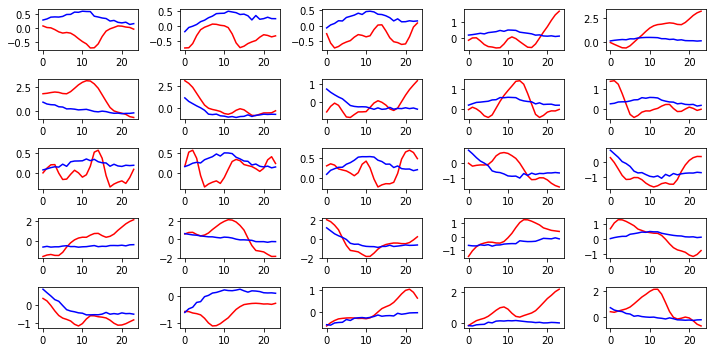

Step: 0, Train Loss: 0.48088306188583374
Step: 20, Train Loss: 0.4549841284751892
Step: 40, Train Loss: 0.464221328496933
Step: 60, Train Loss: 0.3345267176628113
Step: 80, Train Loss: 0.5204396843910217
Step: 100, Train Loss: 0.5974394083023071
Step: 120, Train Loss: 0.4649648368358612
Step: 140, Train Loss: 0.5456514954566956
Epoch: 2, Train loss: 0.45731976240465083
acskill_socre:18.626222241545786, rmse_score:19.424927809517687
Epoch: 2, Valid Score: -0.7987055679719006


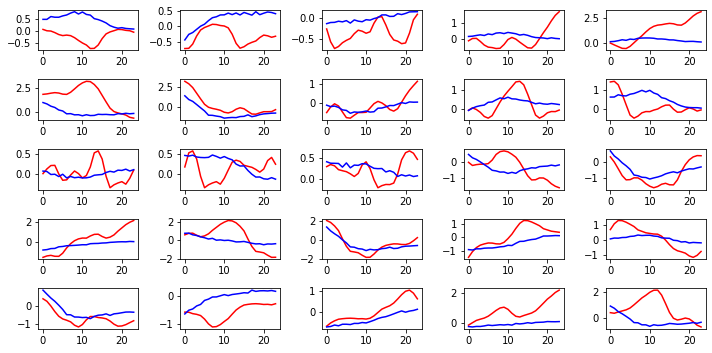

Step: 0, Train Loss: 0.3305143117904663
Step: 20, Train Loss: 0.3143012523651123
Step: 40, Train Loss: 0.2583109140396118
Step: 60, Train Loss: 0.3372926712036133
Step: 80, Train Loss: 0.34254154562950134
Step: 100, Train Loss: 0.4317891001701355
Step: 120, Train Loss: 0.39104995131492615
Step: 140, Train Loss: 0.33795201778411865
Epoch: 3, Train loss: 0.34166290835566715
acskill_socre:23.746488838373214, rmse_score:18.52174668212574
Epoch: 3, Valid Score: 5.224742156247473
Model saved successfully


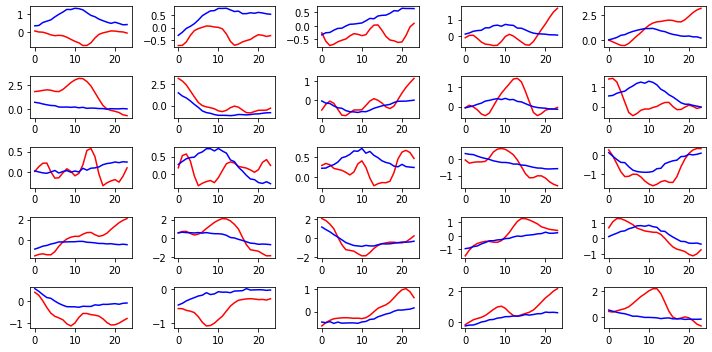

Step: 0, Train Loss: 0.40105557441711426
Step: 20, Train Loss: 0.35035690665245056
Step: 40, Train Loss: 0.15311597287654877
Step: 60, Train Loss: 0.1829882711172104
Step: 80, Train Loss: 0.17278991639614105
Step: 100, Train Loss: 0.2253110706806183
Step: 120, Train Loss: 0.2504797875881195
Step: 140, Train Loss: 0.27966710925102234
Epoch: 4, Train loss: 0.21621449781607274
acskill_socre:22.822759834380925, rmse_score:20.915093345556365
Epoch: 4, Valid Score: 1.9076664888245602


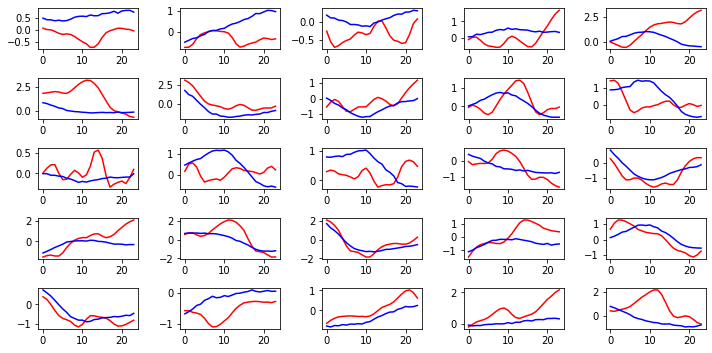

Step: 0, Train Loss: 0.21122775971889496
Step: 20, Train Loss: 0.1315527856349945
Step: 40, Train Loss: 0.197641059756279
Step: 60, Train Loss: 0.12637478113174438
Step: 80, Train Loss: 0.19597379863262177
Step: 100, Train Loss: 0.1721922606229782
Step: 120, Train Loss: 0.24791058897972107
Step: 140, Train Loss: 0.12997403740882874
Epoch: 5, Train loss: 0.16119709478257455
acskill_socre:20.725569777495544, rmse_score:20.496193629777803
Epoch: 5, Valid Score: 0.2293761477177405


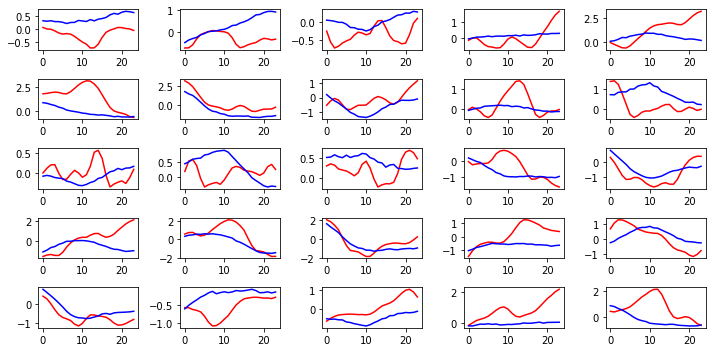

Step: 0, Train Loss: 0.11998003721237183
Step: 20, Train Loss: 0.09143080562353134
Step: 40, Train Loss: 0.112482450902462
Step: 60, Train Loss: 0.1232820376753807
Step: 80, Train Loss: 0.1083340048789978
Step: 100, Train Loss: 0.09577518701553345
Step: 120, Train Loss: 0.18613331019878387
Step: 140, Train Loss: 0.10533007234334946
Epoch: 6, Train loss: 0.12240985658479063
acskill_socre:22.765307923363753, rmse_score:21.851525813751927
Epoch: 6, Valid Score: 0.9137821096118266


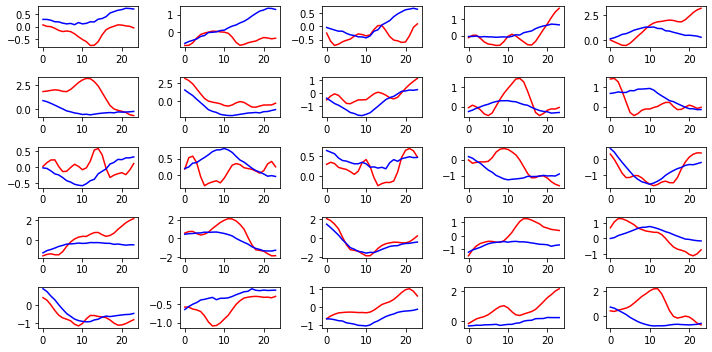

Step: 0, Train Loss: 0.10995613038539886
Step: 20, Train Loss: 0.0702236220240593
Step: 40, Train Loss: 0.08610701560974121
Step: 60, Train Loss: 0.10410036891698837
Step: 80, Train Loss: 0.0889987200498581
Step: 100, Train Loss: 0.08447448909282684
Step: 120, Train Loss: 0.08738090097904205
Step: 140, Train Loss: 0.1153821349143982
Epoch: 7, Train loss: 0.10660333288450764
acskill_socre:20.116324671916292, rmse_score:20.489593037462523
Epoch: 7, Valid Score: -0.373268365546231


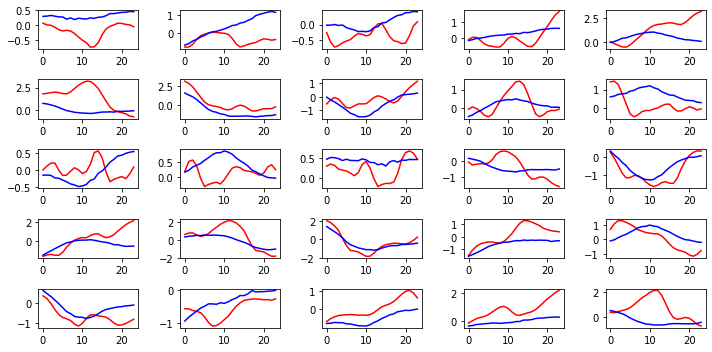

Step: 0, Train Loss: 0.11854221671819687
Step: 20, Train Loss: 0.11844106763601303
Step: 40, Train Loss: 0.07119366526603699
Step: 60, Train Loss: 0.19089524447917938
Step: 80, Train Loss: 0.07716313749551773
Step: 100, Train Loss: 0.12348654121160507
Step: 120, Train Loss: 0.11685250699520111
Step: 140, Train Loss: 0.07564215362071991
Epoch: 8, Train loss: 0.10026129416815222
acskill_socre:22.658938403267072, rmse_score:21.162151486462513
Epoch: 8, Valid Score: 1.4967869168045596


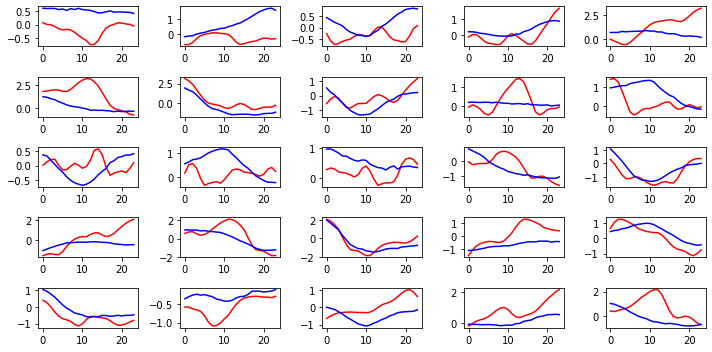

Step: 0, Train Loss: 0.07572385668754578
Step: 20, Train Loss: 0.12058931589126587
Step: 40, Train Loss: 0.08849265426397324
Step: 60, Train Loss: 0.07510028779506683
Step: 80, Train Loss: 0.0720357745885849
Step: 100, Train Loss: 0.07869647443294525


In [ ]:
train(num_epochs=30)

In [94]:
model.load_state_dict(torch.load('models/basemodel_epoch_5.pt'))

<All keys matched successfully>

In [15]:
test_path = './tcdata/enso_round1_test_20210201/'

### load test data
files = os.listdir(test_path)
test_feas_dict = {}
for file in files:
    test_feas_dict[file] = np.load(test_path + file)

In [17]:
### 2. predict
test_predicts_dict = {}
for file_name, val in test_feas_dict.items():
    SST = np.expand_dims(val[:,:,:,0],axis=0)
    T300 = np.expand_dims(val[:,:,:,1],axis=0)
    Ua = np.expand_dims(val[:,:,:,2],axis=0)
    Va = np.expand_dims(val[:,:,:,3],axis=0)
    
    SST = np.nan_to_num(SST) # trans nan to 0
    T300 = np.nan_to_num(T300)
    Ua = np.nan_to_num(Ua)
    Va = np.nan_to_num(Va)
    
    data_list = [SST,T300,Ua,Va]
    SST,T300,Ua,Va = scale_data(data_list)

    SST = torch.tensor(SST).to(device).float()
    T300 = torch.tensor(T300).to(device).float()
    Ua = torch.tensor(Ua).to(device).float()
    Va = torch.tensor(Va).to(device).float()
    
    result = model(SST, T300, Ua, Va).view(-1).detach().cpu().numpy()
    test_predicts_dict[file_name] = result

(20736, 4)


In [9]:
### 3. save results
if os.path.exists('./result/'):  
    shutil.rmtree('./result/', ignore_errors=True)  
os.makedirs('./result/')
for file_name, val in test_predicts_dict.items(): 
    np.save('./result/' + file_name, val)

In [44]:
def make_zip(res_dir='./result', output_dir='result.zip'):  
    z = zipfile.ZipFile(output_dir, 'w')  
    for file in os.listdir(res_dir):  
        if '.npy' not in file:
            continue
        z.write(res_dir + os.sep + file)  
    z.close()

In [45]:
make_zip()

./result/test_0144-01-12.npy
